pip install cmake
pip3 install xgboost

# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## PROJECT OVERVIEW
The project uses simulated data of Starbucks customers behavior on the Starbucks rewards app. Starbucks customers sometimes receive an offer or two for its products. The dataset is a simplified version of the actual data. It only contains offers related to a single product instead of many. The users might receive more than one offer or no offer at all.  

## PROBLEM STATEMENT
The Capstone Challenge Project builds a successful machine learning model which predicts whether customers will most likely complete an offer. The project seeks to help Starbucks on which demographic of customers are most likely to complete its offers. We will explore the following demographics and then choose the one that is mostly suitable for the Machine learning model. They are:

- Income level
- Gender
- Age
- Offer Duration
- How the offer is communicated
- Offer type

These are the areas which are thought to have major impact on the behavior of Starbucks customers. The actual degree to which they matter will become apparent as the dataset is explored. The features seen as the most significant to the completion of offers will be further explored and used where necessary for the model.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(style = 'whitegrid')

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

### Assessment

In [2]:
portfolio#.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
portfolio.shape

(10, 6)

In [4]:
# Check general info
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
# Check value counts of offers
portfolio.id.value_counts()

f19421c1d4aa40978ebb69ca19b0e20d    1
4d5c57ea9a6940dd891ad53e9dbe8da0    1
5a8bc65990b245e5a138643cd4eb9837    1
ae264e3637204a6fb9bb56bc8210ddfd    1
2906b810c7d4411798c6938adc9daaa5    1
9b98b8c7a33c4b65b9aebfe6a799e6d9    1
3f207df678b143eea3cee63160fa8bed    1
fafdcd668e3743c1bb461111dcafc2a4    1
0b1e1539f2cc45b7b9fa7c272da2e1d7    1
2298d6c36e964ae4a3e7e9706d1fb8c2    1
Name: id, dtype: int64

#### Portfolio Assessment issues

- Change position of id
- Change id to offer_id
- Encode Channels and Offer type

#### Cleaning Code

In [6]:
def portfolio_clean(portfolio):
    """ Clean the portfolio dataset.
    - Makes a copy of the dataset
    - Rearrange column position so that id comes first
    - Renames id to offer_id
    - Hot encodes offer type and channels types
    - Merges dataframes
    - Drop channels and offer type columns
    
    Input:
    - portfolio: original dataset
    Returns:
    - portfolio_clean
    """
    # Copy portfolio df
    portfolio_clean = portfolio.copy()
    
    # Rearrange column positions
    portfolio_clean = portfolio_clean[['id', 'channels','difficulty', 'duration', 'offer_type', 'reward']]
    
    # Rename id to offer id
    portfolio_clean.rename(columns={'id': 'offer_id'}, inplace=True)
    
    # Encode Offer types
    offertype_dummy = pd.get_dummies(portfolio_clean['offer_type'])
    
    # Encode Channels types
    channels_dummy = pd.get_dummies(portfolio_clean.channels.apply(pd.Series).stack(),
                             prefix="channel").sum(level=0)
    
    # Concat dummy dfs to portfolio
    portfolio_clean = pd.concat([portfolio_clean, offertype_dummy, channels_dummy], axis=1)
    
    # Drop channels and offer type columns
    portfolio_clean.drop(columns=['channels'], inplace=True)

    return portfolio_clean

In [7]:
# Clean portfolio df and view first few rows
portfolio_clean = portfolio_clean(portfolio)
portfolio_clean.head()

,offer_id,difficulty,duration,offer_type,reward,bogo,discount,informational,channel_email,channel_mobile,channel_social,channel_web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,bogo,10,1,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,bogo,10,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,4,informational,0,0,0,1,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,discount,5,0,1,0,1,0,0,1


## PROFILE DF

In [8]:
# Get first few rows of df
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
# Get the number of rows and columns
profile.shape

(17000, 5)

In [10]:
# Get a sample of df values
profile.sample(5)

,age,became_member_on,gender,id,income
16796,118,20151120,None,c4137a37c33446f2a22f59282865f6c5,NaN
2908,118,20160309,None,d79a422d00674d80a30311c203ad0e6b,NaN
4739,40,20180703,M,1e449ed491f64f1498d25b4160274edc,59000.0
10881,22,20180516,M,207333c76c074708b82abdea3883e76e,56000.0
2060,26,20171206,M,10983bae435748a3a300222adc9ee9ed,39000.0


In [11]:
# Get general information on df
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [12]:
# Find missing values in profile df
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [13]:
# Get summary descriptive statistics
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


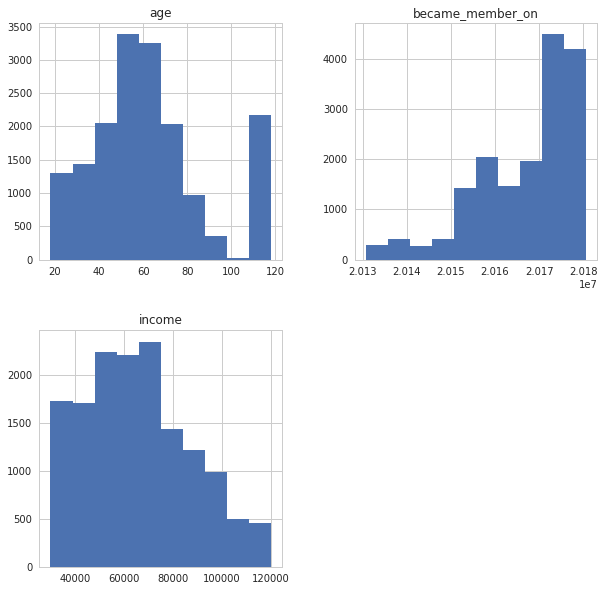

In [14]:
# Plot histogram
profile.hist(figsize=(10,10));

There seems to be a lot of rows with age 118 which is unusual. Lets investigate a little further

In [15]:
# Get df with only age 118
only_118 = profile.query('age == 118')
only_118.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
age                 2175 non-null int64
became_member_on    2175 non-null int64
gender              0 non-null object
id                  2175 non-null object
income              0 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB


In [16]:
# Get shape of df
only_118.shape

(2175, 5)

Those with 118 years are also missing key demographic information such as age and gender

In [17]:
# Lets get the gender counts
gender_counts = profile.gender.value_counts()
gender_counts

M    8484
F    6129
O     212
Name: gender, dtype: int64

#### Profile Assessment Issues

- Change id to customer_id
- Change position of id to first column
- Change became_member_on to date type from integer
- Dummy the gender column
- There are 2175 missing values in the gender and income column

#### Cleaning Code

In [18]:
def clean_profile(profile):
    """ Clean the profile dataset.
    - make a copy of df
    - Remove null values
    - Change the date format
    - Rearrange column position
    - Rename the column name id to profile_id
    - *Create column to identify customers with demographic data
    - Dummy columns for gender
    Input:
    - profile: original dataset
    Returns:
    - profile_clean
    """
    profile_clean = profile.copy()
    
    # Remove customers with null income data and gender
    profile_clean = profile_clean.dropna(subset=['gender', 'income'])
    
    # Change became_member_on to date time type from integer
    date = lambda x: pd.to_datetime(str(x), format='%Y%m%d')
    profile_clean.became_member_on = profile_clean.became_member_on.apply(date)
    
    # Create a new column from "became_member_on" for the number of days since the user is a member of starbucks
    profile_clean['days_as_member'] = pd.to_datetime('today') - profile_clean['became_member_on']
    profile_clean['days_as_member'] = profile_clean['days_as_member'].dt.days
    
    # Rearrange column positions
    profile_clean = profile_clean[['id', 'age','became_member_on', 'days_as_member', 'gender', 'income']]
    
    # Rename id to profile id
    profile_clean.rename(columns={'id': 'customer_id'}, inplace=True)
    
#     # Dummy gender column
#     gender_dummy = pd.get_dummies(profile_clean['gender'])
    
#     # Concat gender_dummy dfs to profile clean
#     profile_clean = pd.concat([profile_clean, gender_dummy], axis=1)
    
#     # Drop channels and offer type columns
#     profile_clean.drop(columns=['gender'], inplace=True)
    

    
    return profile_clean

In [19]:
profile_clean = clean_profile(profile)

In [20]:
import datetime as dt     
date = dt.date.today
date

<function date.today>

In [21]:
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [22]:
# Gender distribution
profile_clean.gender.value_counts()/ profile_clean.shape[0]

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

In [23]:
profile_clean.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

### ANALYSIS
#### EXPLORE RELATIONSHIPS

In [24]:
# Get first few rows of df
profile_clean.head()

,customer_id,age,became_member_on,days_as_member,gender,income
1,0610b486422d4921ae7d2bf64640c50b,55,2017-07-15,1171,F,112000.0
3,78afa995795e4d85b5d9ceeca43f5fef,75,2017-05-09,1238,F,100000.0
5,e2127556f4f64592b11af22de27a7932,68,2018-04-26,886,M,70000.0
8,389bc3fa690240e798340f5a15918d5c,65,2018-02-09,962,M,53000.0
12,2eeac8d8feae4a8cad5a6af0499a211d,58,2017-11-11,1052,M,51000.0


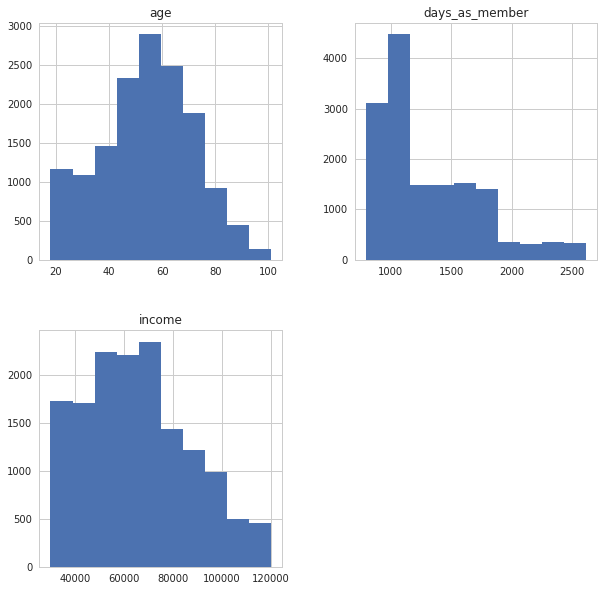

In [25]:
# Plot histogram of df
profile_clean.hist(figsize=(10,10));

In [26]:
profile_clean.describe()

,age,days_as_member,income
count,14825.000000,14825.000000,14825.000000
mean,54.393524,1317.478988,65404.991568
std,17.383705,419.205158,21598.299410
min,18.000000,795.000000,30000.000000
25%,42.000000,1003.000000,49000.000000
50%,55.000000,1153.000000,64000.000000
75%,66.000000,1592.000000,80000.000000
max,101.000000,2618.000000,120000.000000


In [27]:
age_income = profile_clean.groupby('age').mean().income

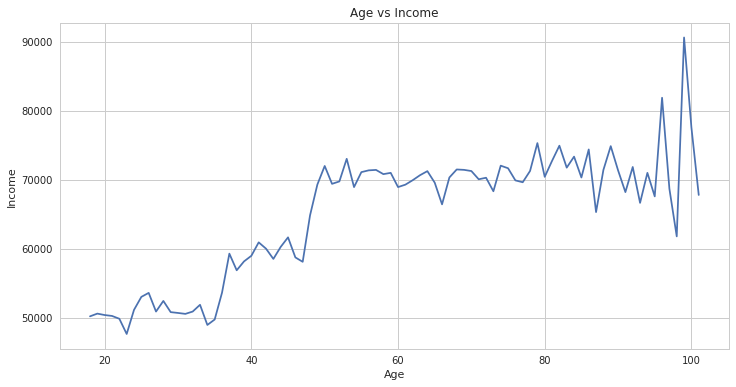

In [28]:
# Plot line chart
plt.figure(figsize=(12,6))
plt.plot(age_income);
plt.xlabel("Age")
plt.ylabel("Income")
plt.title("Age vs Income")
# plt.xticks(rotation=15)
# ytick = np.arange(0, 12+2, 2)
# plt.yticks(ytick)
plt.show();

In [29]:
profile_clean.head()

,customer_id,age,became_member_on,days_as_member,gender,income
1,0610b486422d4921ae7d2bf64640c50b,55,2017-07-15,1171,F,112000.0
3,78afa995795e4d85b5d9ceeca43f5fef,75,2017-05-09,1238,F,100000.0
5,e2127556f4f64592b11af22de27a7932,68,2018-04-26,886,M,70000.0
8,389bc3fa690240e798340f5a15918d5c,65,2018-02-09,962,M,53000.0
12,2eeac8d8feae4a8cad5a6af0499a211d,58,2017-11-11,1052,M,51000.0


In [30]:
# Lets get the gender counts after cleaning
#profile_clean.F.mean(), profile_clean.M.mean(), 

In [31]:
# Membership by year
start_year = profile_clean.groupby(pd.Grouper(key='became_member_on', freq='Y')).count().customer_id
start_year

became_member_on
2013-12-31     274
2014-12-31     662
2015-12-31    1597
2016-12-31    3024
2017-12-31    5599
2018-12-31    3669
Freq: A-DEC, Name: customer_id, dtype: int64

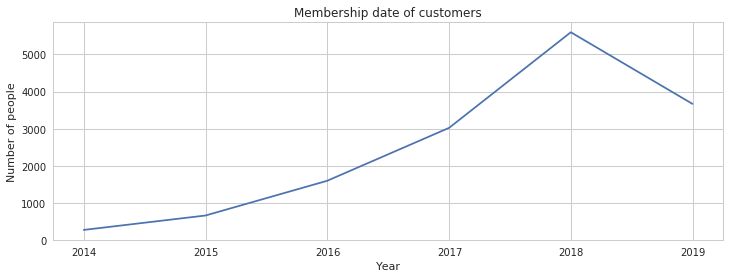

In [32]:
# Plot line chart
plt.figure(figsize=(12,4))
plt.plot(start_year)
plt.xlabel('Year')
plt.ylabel('Number of people')
plt.title('Membership date of customers');

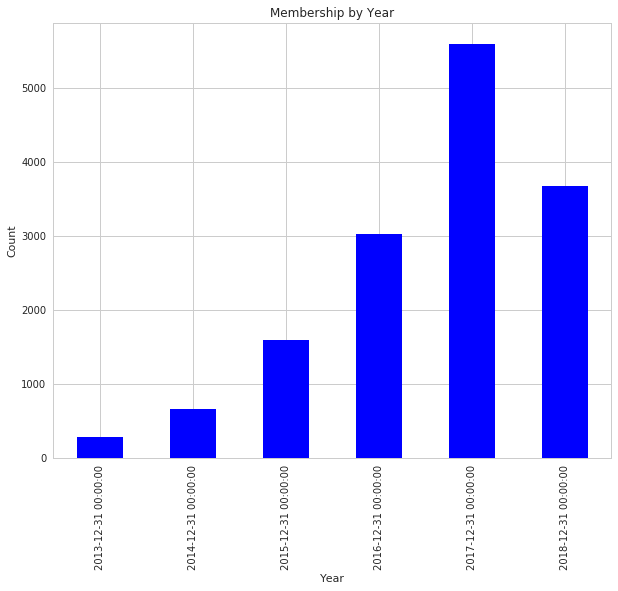

In [33]:
# Plot bar chart
plt.figure(figsize = [10, 8])
start_year.plot(kind="bar", color="blue")
plt.title('Membership by Year')
plt.xlabel('Year')
plt.ylabel('Count');

The membership has been growing year on year except 2018 where it dropped off

In [34]:
# Group by gender and get income
gender_income = profile.groupby('gender').mean().income

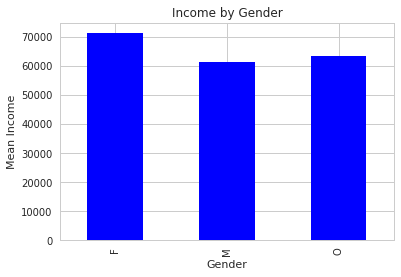

In [35]:
# Plot income by gender bar chart
gender_income.plot(kind="bar", color="blue")
plt.title('Income by Gender')
plt.xlabel('Gender')
plt.ylabel('Mean Income');

### Transcipt


#### ASSESSMENT

In [36]:
# View first few rows of df
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [37]:
# Get sample rows from the dataframe
transcript.sample(5)

,event,person,time,value
149577,offer viewed,638eb4b1d24b48e1bbcb15e5b5326650,402,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
144255,transaction,cc3c53d1212c42d99bcb4a1f016239e3,384,{'amount': 8.77}
191676,transaction,a104f5f8f470487693d626d36317dcf7,468,{'amount': 5.71}
108590,offer viewed,8b187db07b274a9583550f15a397c0d0,318,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
262781,transaction,9b7cf5a50ea1407c84b87fdea5459b87,582,{'amount': 3.07}


In [38]:
# Get general info on dataset
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [39]:
# Get the event counts in the transcript df
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [40]:
transcript.shape

(306534, 4)

#### Transcipt Assessment Issues

- Rename person to customer_id
- Change position of customer_id column to first
- separate value column into offer_id and amount and reward_x and y
- Split event column into 4 and dummy
- Convert time in hours to days and rename column

In [41]:
trans = transcript.copy()
trans.head(2)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [42]:
#Convert from hours to days
trans['time'] /= 24.0
#Rename time to days
trans.rename(columns={'time': 'day'}, inplace=True)

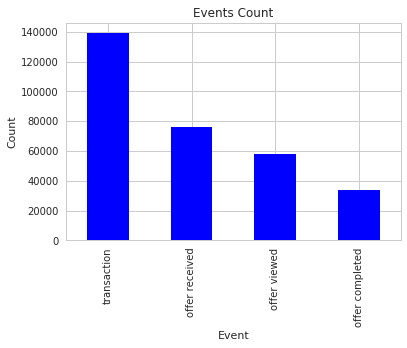

In [43]:
# Get counts of the different events
events = transcript.event.value_counts()
# Plot events bar chart
events.plot(kind="bar", color="blue")
plt.title('Events Count')
plt.xlabel('Event')
plt.ylabel('Count');

#### Cleaning Code

In [44]:
def clean_transcript(transcript):
    
    """ Transforms a DataFrame that contains records for events, customer_id, times and
    values
    Clean the profile dataset:
    - Rename person to customer_id
    - Change position of customer_id column to first
    - separate value column into offer_id and amount and reward_x and y
    - Split event column into 4 and dummy
    - Convert time in hours to days and rename column
    
    INPUT:
        transcript: DataFrame that contains demographic data for each 
                 customer
       
    OUTPUT:
        clean transcript dataframe with
        offer_data: DataFrame that describes customer offer data
        transaction: DataFrame that describes customer transactions
    """
    # Make a copy of transcript df
    transcript_clean = transcript.copy()
    
    # Rearrange column positions
    transcript_clean = transcript_clean[['person', 'event','time', 'value']]
    
    # Rename id to profile id
    transcript_clean.rename(columns={'person': 'customer_id'}, inplace=True)
    
    # Convert from hours to days
    #transcript['time'] /= 24.0
    # Rename time to days
    #transcript_clean.rename(columns={'time': 'day'}, inplace=True)
    
    # Remove customer id's that are not in the customer profile DataFrame
    data = transcript_clean['customer_id'].isin(profile_clean['customer_id'])
    transcript_clean = transcript_clean[data]

    # Split event column into 4 and dummy
    transcript_clean.event = transcript_clean.event.str.replace(' ', '_')
    dummy_event = pd.get_dummies(transcript_clean.event, prefix="event")
    
    # Join transcipt df and dummy table and drop event column
    transcript_clean = pd.concat([transcript_clean, dummy_event], axis=1,
                                 sort=False)
    transcript_clean.drop(columns='event', inplace=True)
    
    # Create an offer_id column
    transcript_clean['offer_id'] =\
            transcript_clean['value'].apply(lambda elem: list(elem.values())[0])
    
    # Create offer_id column from the value column
    transcript_clean['offer_id'] = [[*v.values()][0]
                                    if [*v.keys()][0] in ['offer id',
                                                          'offer_id'] else None
                                    for v in transcript_clean.value]
    # Create amount column from the value column
#     transcript_clean['amount','reward'] = [np.round([*v.values()][0], decimals=2)
#                                   if [*v.keys()][0] == 'amount' else None
#                                   for v in transcript_clean.value]
    
    for i in ["amount", "reward"]:
        transcript_clean[i] = transcript_clean['value'].apply(lambda x: x[i] if i in x else np.nan)
    
    transcript_clean.drop(columns='value', inplace=True)
    
    return transcript_clean

In [45]:
# Clean transcript df
transcript_clean = clean_transcript(transcript)

In [46]:
# View first few rows
transcript_clean.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
5,389bc3fa690240e798340f5a15918d5c,0,0,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,0,0,1,0,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN
8,aa4862eba776480b8bb9c68455b8c2e1,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN


In [47]:
# lets check for duplicated values in the cleaned dfs
transcript_clean.duplicated().sum(), portfolio_clean.duplicated().sum(), profile_clean.duplicated().sum()

(374, 0, 0)

In [48]:
# lets visully inspect the duplicates
dupli = transcript_clean[transcript_clean.duplicated(keep=False)]

In [49]:
# Remove duplicates from transcript_clean
transcript_clean.drop_duplicates(inplace=True)
transcript_clean.reset_index(drop=True, inplace=True)

In [50]:
# Check to see if duplicates have been removed
transcript_clean.duplicated().sum()

0

In [51]:
# Get the shape of all 3 datasets
transcript_clean.shape, profile_clean.shape, portfolio_clean.shape

((272388, 9), (14825, 6), (10, 12))

### OBSERVATION
From exploration of the datasets it can be seen that transcript and profile are related by a common feature customer_id.
The portfolio and transcript datasets have an offer id that can be used to join them. It is a good idea to merge the 3 datasets so as to properly understand the relationships betweent the different features. The current features will be used to build the model as well as new engineered features wherever necessary.


### MERGING OF 3 DATASETS

In [52]:
def merge_datasets(portfolio_clean, profile_clean, transcript_clean):
    """ Merge the three data sets into one
    Input:
    - portfolio_clean
    - profile_clean
    - transcript_clean
    Output:
    - df: merged dataframe
    """
    trans_prof = pd.merge(transcript_clean, profile_clean, on='customer_id',
                          how="left")
    merged_df = pd.merge(trans_prof, portfolio_clean, on='offer_id', how='left')
    # Change the offer ids to a simplied form
    offer_id = {'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo_1',
                '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo_2',
                '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo_3',
                'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo_4',
                '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'disc_1',
                '2298d6c36e964ae4a3e7e9706d1fb8c2': 'disc_2',
                'fafdcd668e3743c1bb461111dcafc2a4': 'disc_3',
                '2906b810c7d4411798c6938adc9daaa5': 'disc_4',
                '3f207df678b143eea3cee63160fa8bed': 'info_1',
                '5a8bc65990b245e5a138643cd4eb9837': 'info_2'}
    merged_df.offer_id = merged_df.offer_id.apply(lambda x: offer_id[x] if x else None)

    return merged_df

In [53]:
# Merge dataframes
merged_df = merge_datasets(portfolio_clean, profile_clean, transcript_clean)

In [54]:
 # Save data to increase reusability and reduce runtime
#merged_df.to_csv('data/processed_data.csv', index = False)

In [55]:
merged_df.head(4)

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,reward_x,age,...,duration,offer_type,reward_y,bogo,discount,informational,channel_email,channel_mobile,channel_social,channel_web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,bogo_3,NaN,NaN,75,...,7.0,bogo,5.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,disc_4,NaN,NaN,68,...,7.0,discount,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
2,389bc3fa690240e798340f5a15918d5c,0,0,1,0,0,bogo_4,NaN,NaN,65,...,5.0,bogo,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
3,2eeac8d8feae4a8cad5a6af0499a211d,0,0,1,0,0,info_1,NaN,NaN,58,...,4.0,informational,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0


In [56]:
merged_df.columns

Index(['customer_id', 'time', 'event_offer_completed', 'event_offer_received',
       'event_offer_viewed', 'event_transaction', 'offer_id', 'amount',
       'reward_x', 'age', 'became_member_on', 'days_as_member', 'gender',
       'income', 'difficulty', 'duration', 'offer_type', 'reward_y', 'bogo',
       'discount', 'informational', 'channel_email', 'channel_mobile',
       'channel_social', 'channel_web'],
      dtype='object')

#### EXPLORING MERGED DATA SETS

In [57]:
# View first few rows of merged df
pd.set_option('display.max_columns',28)
merged_df.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,reward_x,age,became_member_on,days_as_member,gender,income,difficulty,duration,offer_type,reward_y,bogo,discount,informational,channel_email,channel_mobile,channel_social,channel_web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,bogo_3,NaN,NaN,75,2017-05-09,1238,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,disc_4,NaN,NaN,68,2018-04-26,886,M,70000.0,10.0,7.0,discount,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
2,389bc3fa690240e798340f5a15918d5c,0,0,1,0,0,bogo_4,NaN,NaN,65,2018-02-09,962,M,53000.0,5.0,5.0,bogo,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
3,2eeac8d8feae4a8cad5a6af0499a211d,0,0,1,0,0,info_1,NaN,NaN,58,2017-11-11,1052,M,51000.0,0.0,4.0,informational,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
4,aa4862eba776480b8bb9c68455b8c2e1,0,0,1,0,0,disc_1,NaN,NaN,61,2017-09-11,1113,F,57000.0,20.0,10.0,discount,5.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [58]:
merged_df.shape

(272388, 25)

In [59]:
merged_df.event_offer_completed.value_counts()

0    240318
1     32070
Name: event_offer_completed, dtype: int64

In [60]:
merged_df.event_offer_received.value_counts()

0    205887
1     66501
Name: event_offer_received, dtype: int64

In [61]:
merged_df.event_offer_viewed.value_counts()

0    222528
1     49860
Name: event_offer_viewed, dtype: int64

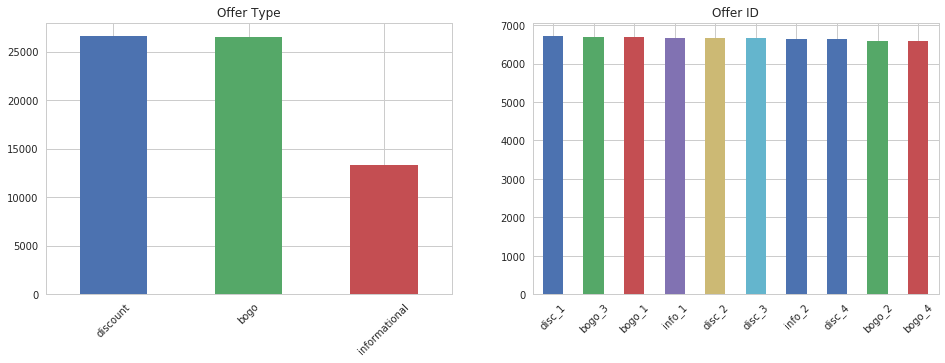

In [62]:
# Plot the different offer types and Id to see distribution
plt.subplot(121)
merged_df[merged_df.event_offer_received == 1].offer_type.value_counts().plot(kind='bar', rot=45, figsize=(16,5))
plt.title('Offer Type');

plt.subplot(122)
merged_df[merged_df.event_offer_received == 1].offer_id.value_counts().plot(kind='bar', rot=45)
plt.title('Offer ID');

#### Observation
- The discount and bogo offer types have higher numbers than the informational offer
The offers ids were sent out approximately the same number of times. They were uniformly distributed.

In [63]:
# shape of df
merged_df.shape

(272388, 25)

In [64]:
merged_df.query('amount != "Nan"').shape

(123957, 25)

In [65]:
merged_df.difficulty.value_counts()

10.0    64358
5.0     31285
0.0     22660
7.0     17881
20.0    12247
Name: difficulty, dtype: int64

In [66]:
# Create a df of only completed offers
completed_offer = merged_df[(merged_df['event_offer_completed'] == 1)]

In [67]:
# Get the counts of the various completed offers
offer_comp = completed_offer.offer_id.value_counts()

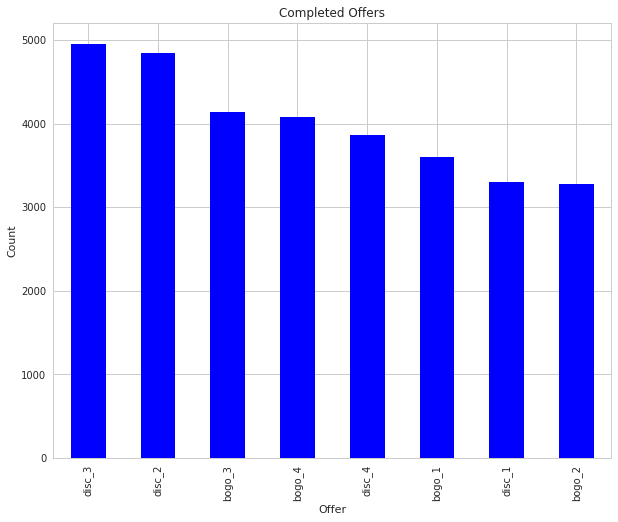

In [68]:
# Plot bar chart of completed offers
plt.figure(figsize = [10, 8])
offer_comp.plot(kind="bar", color="blue")
plt.title('Completed Offers')
plt.xlabel('Offer')
plt.ylabel('Count');

The most completed offers are disc_3 while the least is bogo_2

Now lets see how these completed offer fare by gender

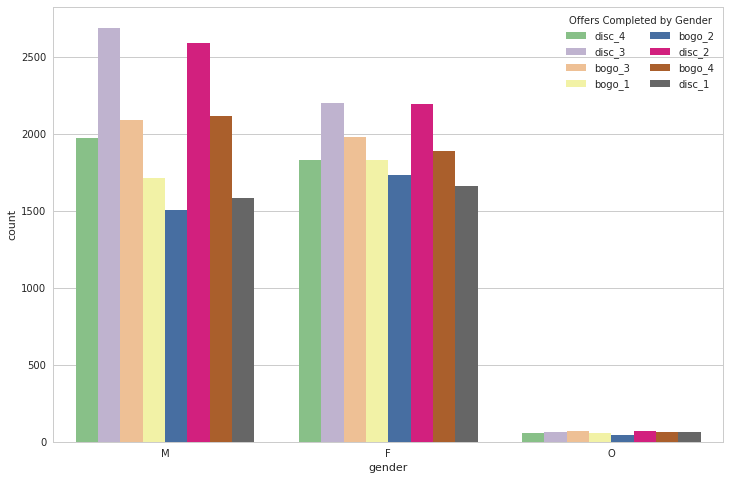

In [69]:
# Plot bar chart
plt.figure(figsize = [12, 8])
ax = sb.countplot(data = completed_offer, x = 'gender', hue = 'offer_id', palette='Accent')
ax.legend(loc = 1, ncol = 2, framealpha = 1, title = "Offers Completed by Gender");

The plot of completed offers by Gender shows more Males have completed offers than females. The other category shows no significant differences between the offers. The difference between the male and female completed offers might be due to the males having a higher number than the females.The offers disc_2 and disc_3 have the most conversions. This is something Startbucks can look at.

In [70]:
# Get completed offer by year
year_comp = completed_offer.groupby(pd.Grouper(key='became_member_on', freq='Y')).count().event_offer_completed
year_comp

became_member_on
2013-12-31      558
2014-12-31     1308
2015-12-31     4262
2016-12-31     8836
2017-12-31    11987
2018-12-31     5119
Freq: A-DEC, Name: event_offer_completed, dtype: int64

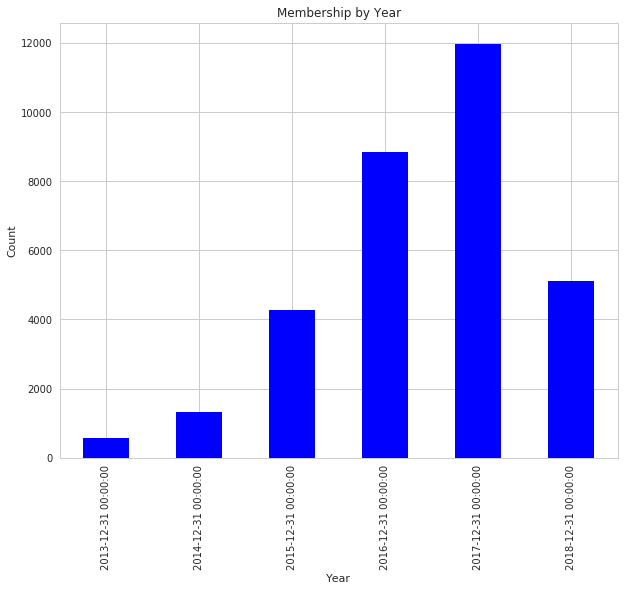

In [71]:
plt.figure(figsize = [10, 8])
year_comp.plot(kind="bar", color="blue")
plt.title('Membership by Year')
plt.xlabel('Year')
plt.ylabel('Count');

The completed offers have been rising year on year. They dropped off in 2018 

Lets see the distribution of completed offers to those not completed

In [72]:
comp = len(merged_df[merged_df['event_offer_completed'] == 1])
not_comp = len(merged_df) - comp
comp, not_comp

(32070, 240318)

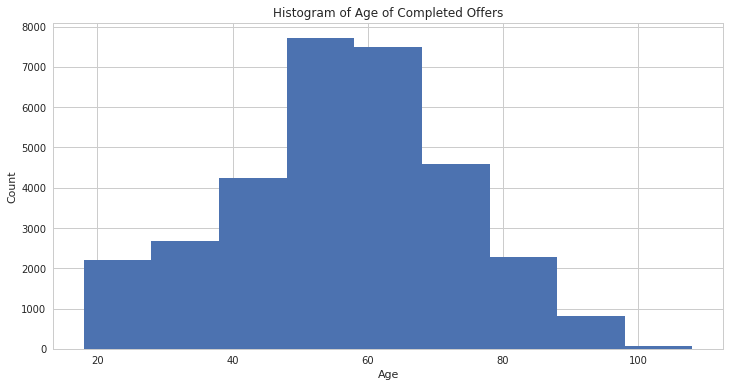

In [73]:
# Plot histogram of Age to see distribution
plt.figure(figsize = [12, 6])
bins = np.arange(18, 101+10, 10)
plt.hist(data = completed_offer, x = 'age', bins=bins)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Age of Completed Offers');

Those between the ages of 50 and 78 have completed the most offers

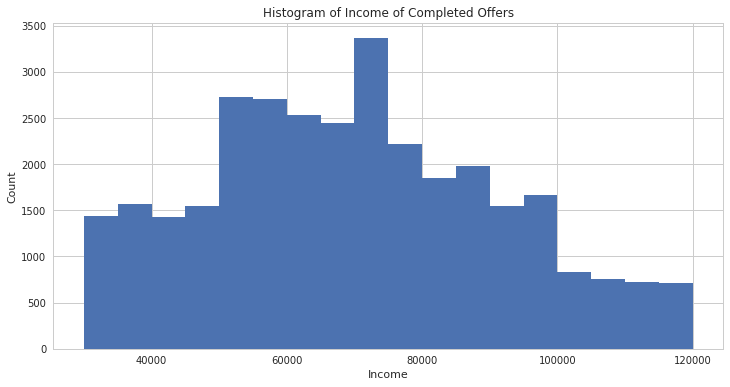

In [74]:
# Plot histogram of Income to see distribution
plt.figure(figsize = [12, 6])
bins = np.arange(30000, 120000+5000, 5000)
plt.hist(data = completed_offer, x = 'income', bins=bins)
plt.xlabel('Income')
plt.ylabel('Count')
plt.title('Histogram of Income of Completed Offers');

Histogram is normally distributed. Those earning between 50000 to 80000 have the highest numbers of completed offers

The merged_df has 25 columns for now. The columns will be used as variable in our Machine Learning model and as the model is tuned further preprocessing might be needed. The most important features to predicting target variable "event_offer_completed" will be used.  

### MODELING

## Build a machine learning model that predicts whether an offer will be completed and the features that are most relevant

In [75]:
# Read in relevant libraries and packages 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import minmax_scale
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

### DATA PREPROCESSING

#### Here we continue to prepare the data to be used in a model:
- Create dummies for the offer id, gender and year columns
- Aggregate features
- Normalize columns ('time', 'income', 'days_as_member', 'duration', 'age', 'amount')

#### MODELS

- Write functions to to extract train and test data
- Use Random Forest regressor for baseline model with all dafualt features 
- Write function to evaluate model
- Tune model using correlation between features then use variables in Random Forest Regressor, XGboost, LogisticRegression and   DecisionTreeRegressor Model
- Evaluate model using RMSE and Cross validation
- Further tune model using Pipelines, Standartd scalar, XGBoost and GridSearchSV
- Evaluate model
- Use Best Parameters
- Find best features for predicting event offer completion

In [76]:
merged_df.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,reward_x,age,became_member_on,days_as_member,gender,income,difficulty,duration,offer_type,reward_y,bogo,discount,informational,channel_email,channel_mobile,channel_social,channel_web
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,bogo_3,NaN,NaN,75,2017-05-09,1238,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,disc_4,NaN,NaN,68,2018-04-26,886,M,70000.0,10.0,7.0,discount,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
2,389bc3fa690240e798340f5a15918d5c,0,0,1,0,0,bogo_4,NaN,NaN,65,2018-02-09,962,M,53000.0,5.0,5.0,bogo,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
3,2eeac8d8feae4a8cad5a6af0499a211d,0,0,1,0,0,info_1,NaN,NaN,58,2017-11-11,1052,M,51000.0,0.0,4.0,informational,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
4,aa4862eba776480b8bb9c68455b8c2e1,0,0,1,0,0,disc_1,NaN,NaN,61,2017-09-11,1113,F,57000.0,20.0,10.0,discount,5.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [77]:
def dummy_offer(merged_df):
    """ Dummy offer_id columns with 0s and 1s
    - join to merged df
    - drop offer id column
    Input:
    - merged_df
    Output:
    - df: Dataframe with dummy offer id columns
    """
    offer_dummy = pd.get_dummies(merged_df['offer_id'])
   # Concat dummy dfs to model_df
    offer_concat = pd.concat([merged_df, offer_dummy], axis=1)
    # Drop channels and offer type columns
    dummy_df = offer_concat.drop(columns=['offer_id'])
    
    return dummy_df

In [78]:
# Use function to get df
model_df = dummy_offer(merged_df)

In [79]:
pd.set_option('display.max_columns',50)
# View first few lines of df
model_df.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,amount,reward_x,age,became_member_on,days_as_member,gender,income,difficulty,duration,offer_type,reward_y,bogo,discount,informational,channel_email,channel_mobile,channel_social,channel_web,bogo_1,bogo_2,bogo_3,bogo_4,disc_1,disc_2,disc_3,disc_4,info_1,info_2
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,NaN,NaN,75,2017-05-09,1238,F,100000.0,5.0,7.0,bogo,5.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0,0,1,0,0,0,0,0,0,0
1,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,NaN,NaN,68,2018-04-26,886,M,70000.0,10.0,7.0,discount,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0,0,0,0,0,0,0,1,0,0
2,389bc3fa690240e798340f5a15918d5c,0,0,1,0,0,NaN,NaN,65,2018-02-09,962,M,53000.0,5.0,5.0,bogo,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0,0,0,1,0,0,0,0,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0,0,1,0,0,NaN,NaN,58,2017-11-11,1052,M,51000.0,0.0,4.0,informational,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0,0,0,0,0,0,0,0,1,0
4,aa4862eba776480b8bb9c68455b8c2e1,0,0,1,0,0,NaN,NaN,61,2017-09-11,1113,F,57000.0,20.0,10.0,discount,5.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,0,0,1,0,0,0,0,0


In [80]:
model_df.shape

(272388, 34)

In [81]:
# Get list of df columns
model_df.columns

Index(['customer_id', 'time', 'event_offer_completed', 'event_offer_received',
       'event_offer_viewed', 'event_transaction', 'amount', 'reward_x', 'age',
       'became_member_on', 'days_as_member', 'gender', 'income', 'difficulty',
       'duration', 'offer_type', 'reward_y', 'bogo', 'discount',
       'informational', 'channel_email', 'channel_mobile', 'channel_social',
       'channel_web', 'bogo_1', 'bogo_2', 'bogo_3', 'bogo_4', 'disc_1',
       'disc_2', 'disc_3', 'disc_4', 'info_1', 'info_2'],
      dtype='object')

In [82]:
# Aggregate the model df
model_df = model_df.groupby(['customer_id' ]).agg(
    {    'time':'mean',
         'event_offer_completed':'sum',   
         'event_offer_received':'sum', 
         'event_offer_viewed':'sum',
         'event_transaction':'sum', 
         'amount':'sum',
         'reward_x':'sum',
         'age':'last',
         'became_member_on':'last',
         'days_as_member':'last',            
         'gender':'last',
         'income':'last',
         'difficulty':'sum',
         'duration':'mean',
         'reward_y':'sum',
         'bogo':'sum',
         'discount':'sum',
         'informational':'sum',
         'channel_email':'sum',
         'channel_mobile':'sum',
         'channel_social':'sum',
         'channel_web':'sum',
         'bogo_1':'sum',
         'bogo_2':'sum',
         'bogo_3':'sum',
         'bogo_4':'sum',
         'disc_1':'sum',
         'disc_2':'sum',
         'disc_3':'sum',
         'disc_4':'sum',
         'info_1':'sum',
         'info_2':'sum'
        
    }
).reset_index()

In [83]:
model_df.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,amount,reward_x,age,became_member_on,days_as_member,gender,income,difficulty,duration,reward_y,bogo,discount,informational,channel_email,channel_mobile,channel_social,channel_web,bogo_1,bogo_2,bogo_3,bogo_4,disc_1,disc_2,disc_3,disc_4,info_1,info_2
0,0009655768c64bdeb2e877511632db8f,470.700000,3,5,4,8,127.60,9.0,33,2017-04-21,1256,M,72000.0,65.0,6.083333,25.0,3.0,5.0,4.0,12.0,12.0,8.0,10.0,0,0,0,3,0,0,3,2,2,2
1,0011e0d4e6b944f998e987f904e8c1e5,365.000000,3,5,5,5,79.46,13.0,40,2018-01-09,993,O,57000.0,96.0,6.615385,39.0,3.0,6.0,4.0,13.0,10.0,5.0,11.0,0,0,3,0,3,3,0,0,2,2
2,0020c2b971eb4e9188eac86d93036a77,335.684211,3,5,3,8,196.86,14.0,59,2016-03-04,1669,F,90000.0,90.0,7.090909,50.0,4.0,5.0,2.0,11.0,11.0,11.0,8.0,1,3,0,0,0,0,5,0,0,2
3,0020ccbbb6d84e358d3414a3ff76cffd,374.869565,3,4,4,12,154.05,13.0,24,2016-11-11,1417,F,60000.0,51.0,5.727273,39.0,6.0,3.0,2.0,11.0,11.0,8.0,9.0,0,0,3,3,0,3,0,0,0,2
4,003d66b6608740288d6cc97a6903f4f0,390.600000,3,5,4,18,48.34,9.0,26,2017-06-21,1195,F,73000.0,100.0,7.833333,22.0,0.0,8.0,4.0,12.0,10.0,8.0,10.0,0,0,0,0,2,0,6,0,2,2


In [84]:
# Check if there are any null values
model_df.isnull().sum()

customer_id              0
time                     0
event_offer_completed    0
event_offer_received     0
event_offer_viewed       0
event_transaction        0
amount                   0
reward_x                 0
age                      0
became_member_on         0
days_as_member           0
gender                   0
income                   0
difficulty               0
duration                 5
reward_y                 0
bogo                     0
discount                 0
informational            0
channel_email            0
channel_mobile           0
channel_social           0
channel_web              0
bogo_1                   0
bogo_2                   0
bogo_3                   0
bogo_4                   0
disc_1                   0
disc_2                   0
disc_3                   0
disc_4                   0
info_1                   0
info_2                   0
dtype: int64

### BASELINE MODEL

In [85]:
def clean_model_df(df):
    """ Cleans a DataFrame that contains features in preparation for test train split
    Clean the model dataset:
    - Dummy the gender column with 1s and 0s
    - Get year from became a member column and dummy it
    - Fill missing values in numeric columns with mean
    - Normalize columns
    - Drop columns
    
    INPUT:
        model_df: DataFrame that contains all features for model
       
    OUTPUT:
        clean model dataframe with

    """
    
    
    # Dummy gender column
    gender_dummy = pd.get_dummies(df['gender'])
    
    # Get year only
    year_only = df['became_member_on'].dt.year
    
    # Dummy year only
    year_dummies = pd.get_dummies(year_only).astype(int)
    
    # Dummy offer_id column
    #offer_dummy = pd.get_dummies(df['offer_id'])
    
    
    
#     For age use function process_cut
#     cut_points = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#     df['age_cat'] = pd.cut(df['age'], cut_points)
#     age_dummies = pd.get_dummies(df['age_cat'])
    
    #diff_dummy = pd.get_dummies(df['difficulty'])
    
    # Addition for df
        
    # Fill numeric columns with the mean
    # The numeric columns are alot fewer than the categorical column and the missing values are relatively small
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)

    # Normalize columns
    
    column_normalize = ['time', 'income', 'days_as_member', 'duration', 'age', 'amount'] #'reward_x', 'reward_y', #'difficulty'

    for col in column_normalize:
        df[col] = minmax_scale(df[col])
    
    # Concat dummy dfs to model_df
    model_df = pd.concat([df, year_dummies], axis=1)

    
    
   # Drop channels and offer type columns
    model_df = model_df.drop(columns=['gender', 'became_member_on']) #, 'age', 'age_cat',
                                     #]) #'reward_x'
    
    
    return model_df
    

In [86]:
# Use clean model df to clean model df and view first fews rows
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns',37)
model_df = clean_model_df(model_df)
model_df.head()

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,amount,reward_x,age,days_as_member,income,difficulty,duration,reward_y,bogo,discount,informational,channel_email,channel_mobile,channel_social,channel_web,bogo_1,bogo_2,bogo_3,bogo_4,disc_1,disc_2,disc_3,disc_4,info_1,info_2,2013,2014,2015,2016,2017,2018
0,0009655768c64bdeb2e877511632db8f,0.752755,3,5,4,8,0.079319,9.0,0.180723,0.252880,0.466667,65.0,0.440476,25.0,3.0,5.0,4.0,12.0,12.0,8.0,10.0,0,0,0,3,0,0,3,2,2,2,0,0,0,0,1,0
1,0011e0d4e6b944f998e987f904e8c1e5,0.529961,3,5,5,5,0.049394,13.0,0.265060,0.108612,0.300000,96.0,0.516484,39.0,3.0,6.0,4.0,13.0,10.0,5.0,11.0,0,0,3,0,3,3,0,0,2,2,0,0,0,0,0,1
2,0020c2b971eb4e9188eac86d93036a77,0.468169,3,5,3,8,0.122373,14.0,0.493976,0.479430,0.666667,90.0,0.584416,50.0,4.0,5.0,2.0,11.0,11.0,11.0,8.0,1,3,0,0,0,0,5,0,0,2,0,0,0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,0.550764,3,4,4,12,0.095761,13.0,0.072289,0.341196,0.333333,51.0,0.389610,39.0,6.0,3.0,2.0,11.0,11.0,8.0,9.0,0,0,3,3,0,3,0,0,0,2,0,0,0,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,0.583921,3,5,4,18,0.030049,9.0,0.096386,0.219419,0.477778,100.0,0.690476,22.0,0.0,8.0,4.0,12.0,10.0,8.0,10.0,0,0,0,0,2,0,6,0,2,2,0,0,0,0,1,0


In [87]:
# GEt shape of model
model_df.shape

(14825, 37)

In [88]:
# Check again if there are any null values
model_df.isnull().sum()

customer_id              0
time                     0
event_offer_completed    0
event_offer_received     0
event_offer_viewed       0
event_transaction        0
amount                   0
reward_x                 0
age                      0
days_as_member           0
income                   0
difficulty               0
duration                 0
reward_y                 0
bogo                     0
discount                 0
informational            0
channel_email            0
channel_mobile           0
channel_social           0
channel_web              0
bogo_1                   0
bogo_2                   0
bogo_3                   0
bogo_4                   0
disc_1                   0
disc_2                   0
disc_3                   0
disc_4                   0
info_1                   0
info_2                   0
2013                     0
2014                     0
2015                     0
2016                     0
2017                     0
2018                     0
d

In [89]:
def train_test_data(df):
    '''
    Function to make train and test data
    
    INPUT:
    model_df - data set having features and target variables
    
    OUTPUT:
    x_train - training feature variables
    x_test - testing feature variables
    y_train - training target variable
    y_test - testing target variable
    
    '''
    # Setting target variable to 'amount'
    y = df['event_offer_completed']
    
    # Making feature data set by removing target variable 'amount' from it
    # We also remove 'customer_id' column as it gives no information to model
    x = df.drop(['event_offer_completed', 'customer_id'], axis=1)
    
    # Making training and testing data sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    
#     from sklearn.datasets import make_classification
#     from sklearn.model_selection import StratifiedKFold
#     # generate 2 class dataset
#     x, y = make_classification(n_samples=10000, n_classes=2, weights=[0.99, 0.01], flip_y=0, random_state=1)
#     kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
#     # enumerate the splits and summarize the distributions
#     for train_ix, test_ix in kfold.split(x, y):
#         #select rows
#         x_train, x_test = x[train_ix], x[test_ix]
#         y_train, y_test = y[train_ix], y[test_ix]
    
    return x_train, x_test, y_train, y_test

In [90]:
# Make the training and testing data sets
x_train, x_test, y_train, y_test = train_test_data(model_df)

In [91]:
    # Setting target variable to 'amount'
y = model_df['event_offer_completed']
    
    # Making feature data set by removing target variable 'amount' from it
    # We also remove 'customer_id' column as it gives no information to model
x = model_df.drop(['event_offer_completed', 'customer_id'], axis=1)

In [92]:
from sklearn.metrics import mean_squared_error, make_scorer
model = RandomForestRegressor()

# Fitting model instance on training data
model.fit(x_train, y_train)
    
# Model predictions on train data 
y_train_predict = model.predict(x_train)

# Model predictions on test data 
y_test_predict = model.predict(x_test)
my_s = make_scorer(mean_squared_error)
scores = cross_val_score(model, x, y, cv=5, scoring=my_s)
np.sqrt(scores).mean()

0.14818299486156403

In [93]:
def model_evaluate(x_train, x_test, y_train, y_test, model):
    '''
    Function to take in the training and testing data and evaluate model performance
    
    INPUT:
    model - model instance to use
    x_train - training feature variables
    x_test - testing feature variables
    y_train - training target variable
    y_test - testing target variable
    Output:
    train_rmse - Root Mean Squared Error on Training Data
    test_rmse - Root Mean Squared Error on Testing Data
    
    '''
       
    # Fit model instance on training data
    model.fit(x_train, y_train)
    
    # Model predictions on train data 
    y_train_predict = model.predict(x_train)

    # Model predictions on test data 
    y_test_predict = model.predict(x_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_predict))

    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_predict))
    
    return train_rmse, test_rmse

In [94]:
model = RandomForestRegressor()
train_rmse, test_rmse = model_evaluate(x_train, x_test, y_train, y_test, model)
print("Baseline Random Forest model performance:- Train RMSE error: {}, Test RMSE error: {}".format(train_rmse, test_rmse))

Baseline Random Forest model performance:- Train RMSE error: 0.07048203364396896, Test RMSE error: 0.1419133132909264


In [95]:
# Get the mean absolute error of the model

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_train, y_train_predict))

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_test_predict))

Mean Absolute Error (MAE): 0.0204394333622
Mean Absolute Error (MAE): 0.0528776978417


- The cross validation test score was 0.14193026981757537
- Train RMSE error: 0.06849896017848293
- Test RMSE error: 0.14594334665086545

## TUNE WITH CORRELATION

Lets see if we can get better results by reducing number of features and only using those most correlated with the target varialble

In [96]:
model_df.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,amount,reward_x,age,days_as_member,income,difficulty,duration,reward_y,bogo,discount,informational,channel_email,channel_mobile,channel_social,channel_web,bogo_1,bogo_2,bogo_3,bogo_4,disc_1,disc_2,disc_3,disc_4,info_1,info_2,2013,2014,2015,2016,2017,2018
0,0009655768c64bdeb2e877511632db8f,0.752755,3,5,4,8,0.079319,9.0,0.180723,0.252880,0.466667,65.0,0.440476,25.0,3.0,5.0,4.0,12.0,12.0,8.0,10.0,0,0,0,3,0,0,3,2,2,2,0,0,0,0,1,0
1,0011e0d4e6b944f998e987f904e8c1e5,0.529961,3,5,5,5,0.049394,13.0,0.265060,0.108612,0.300000,96.0,0.516484,39.0,3.0,6.0,4.0,13.0,10.0,5.0,11.0,0,0,3,0,3,3,0,0,2,2,0,0,0,0,0,1
2,0020c2b971eb4e9188eac86d93036a77,0.468169,3,5,3,8,0.122373,14.0,0.493976,0.479430,0.666667,90.0,0.584416,50.0,4.0,5.0,2.0,11.0,11.0,11.0,8.0,1,3,0,0,0,0,5,0,0,2,0,0,0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,0.550764,3,4,4,12,0.095761,13.0,0.072289,0.341196,0.333333,51.0,0.389610,39.0,6.0,3.0,2.0,11.0,11.0,8.0,9.0,0,0,3,3,0,3,0,0,0,2,0,0,0,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,0.583921,3,5,4,18,0.030049,9.0,0.096386,0.219419,0.477778,100.0,0.690476,22.0,0.0,8.0,4.0,12.0,10.0,8.0,10.0,0,0,0,0,2,0,6,0,2,2,0,0,0,0,1,0


In [97]:
# Set target variable
y = model_df['event_offer_completed']
    
# Making feature data set by removing target variable 'amount' from it
# Set feature variables. Remove target variable and also remove 'customer_id' column as it gives no information to model
X = model_df.drop(['customer_id', 'event_offer_completed'], axis=1)
num_feats = 15

In [98]:
# Find top 15 correlated variables with event offer completion
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y,num_feats)
print(str(len(cor_feature)), 'selected features')

15 selected features


In [99]:
# Get list of features
feature_name = X.columns.tolist()
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)

,Feature,Pearson,Total
1,reward_y,True,1
2,reward_x,True,1
3,event_transaction,True,1
4,event_offer_viewed,True,1
5,event_offer_received,True,1
6,duration,True,1
7,discount,True,1
8,difficulty,True,1
9,channel_web,True,1
10,channel_social,True,1


In [100]:
def train_test_data_2(model_df):
    '''
    Function to make train and test data
    
    INPUT:
    model_df - data set having features and target variables
    
    OUTPUT:
    x_train - training feature variables
    x_test - testing feature variables
    y_train - training target variable
    y_test - testing target variable
    
    '''
    # Setting target variable to 'amount'
    y = model_df['event_offer_completed']
    
    # Making feature data set by removing target variable 'amount' from it
    # We also remove 'customer_id' column as it gives no information to model
    x = model_df[['reward_x', 'reward_y', 'event_transaction', 'event_offer_viewed', 'event_offer_received', 'duration',
                      'discount', 'difficulty', 'channel_web','channel_web', 'channel_social', 'channel_mobile', 
                      'channel_email', 'bogo', 'amount']]
    x = x.loc[:,~x.columns.duplicated()]
    # Making training and testing data sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
#     from sklearn.datasets import make_classification
#     from sklearn.model_selection import StratifiedKFold
#     # generate 2 class dataset
#     x, y = make_classification(n_samples=10000, n_classes=2, weights=[0.99, 0.01], flip_y=0, random_state=1)
#     kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
#     # enumerate the splits and summarize the distributions
#     for train_ix, test_ix in kfold.split(x, y):
#         #select rows
#         x_train, x_test = x[train_ix], x[test_ix]
#         y_train, y_test = y[train_ix], y[test_ix]
    
    return x_train, x_test, y_train, y_test

In [101]:
# Making training and testing data sets
x_train, x_test, y_train, y_test = train_test_data_2(model_df)

In [102]:
    # Setting target variable to 'amount'
y = model_df['event_offer_completed']
    
    # Making feature data set by removing target variable 'amount' from it
    # We also remove 'customer_id' column as it gives no information to model
x = model_df[['reward_x', 'reward_y', 'event_transaction', 'event_offer_viewed', 'event_offer_received', 'duration',
                    'discount', 'difficulty', 'channel_web','channel_web', 'channel_social', 'channel_mobile', 
                    'channel_email', 'bogo', 'amount']]
x = x.loc[:,~x.columns.duplicated()]
# Making training and testing data sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### XGB REGRESSOR MODEL

In [103]:
# Choose model
model = XGBRegressor()

# Fitting model instance on training data
model.fit(x_train, y_train)
    
# Model predictions on train data 
y_train_predict = model.predict(x_train)

# Model predictions on test data 
y_test_predict = model.predict(x_test)
my_xgb = make_scorer(mean_squared_error)
scores_5 = cross_val_score(model, x, y, cv=5, scoring=my_xgb)
xgb_score = np.sqrt(scores).mean()

In [104]:
print("Xgb Cross validation Test Score: {}".format(xgb_score))

Xgb Cross validation Test Score: 0.14818299486156403


In [105]:
# Evaluate model
train_rmse_5, test_rmse_5 = model_evaluate(x_train, x_test, y_train, y_test, model)

In [106]:
print("xbg Regressor model performance:- Train RMSE error: {}, Test RMSE error: {}".format(train_rmse_5, test_rmse_5))

xbg Regressor model performance:- Train RMSE error: 0.05210123211145401, Test RMSE error: 0.12047526985406876


In [107]:
print('Mean Absolute Error Train (MAE):', metrics.mean_absolute_error(y_train, y_train_predict))

print('Mean Absolute Error Test (MAE):', metrics.mean_absolute_error(y_test, y_test_predict))

Mean Absolute Error Train (MAE): 0.0329986
Mean Absolute Error Test (MAE): 0.0711941


### RANDOM FOREST REGRESSOR MODEL

In [108]:
# Choose model
model = RandomForestRegressor()

# Fitting model instance on training data
model.fit(x_train, y_train)
    
# Model predictions on train data 
y_train_predict = model.predict(x_train)

# Model predictions on test data 
y_test_predict = model.predict(x_test)
my_for = make_scorer(mean_squared_error)
scores_2 = cross_val_score(model, x, y, cv=5, scoring=my_for)
rfg_score = np.sqrt(scores_2).mean()

In [109]:
print("Random Forest Cross validation Test Score: {}".format(rfg_score))

Random Forest Cross validation Test Score: 0.14986706584227955


In [110]:
# Evaluate model
train_rmse_2, test_rmse_2 = model_evaluate(x_train, x_test, y_train, y_test, model)

In [111]:
print("Correlated Random Forest model performance:- Train RMSE error: {}, Test RMSE error: {}".format(train_rmse_2, test_rmse_2))

Correlated Random Forest model performance:- Train RMSE error: 0.06516078955715371, Test RMSE error: 0.1524234682359142


In [112]:
print('Mean Absolute Error Train (MAE):', metrics.mean_absolute_error(y_train, y_train_predict))

print('Mean Absolute Error Test (MAE):', metrics.mean_absolute_error(y_test, y_test_predict))

Mean Absolute Error Train (MAE): 0.0198708682664
Mean Absolute Error Test (MAE): 0.0549685251799


### LOGISTIC REGRESSION MODEL

In [113]:
# Choose model
model = LogisticRegression()

# Fitting model instance on training data
model.fit(x_train, y_train)
    
# Model predictions on train data 
y_train_predict = model.predict(x_train)

# Model predictions on test data 
y_test_predict = model.predict(x_test)
my_log = make_scorer(mean_squared_error)
scores_3 = cross_val_score(model, x, y, cv=5, scoring=my_log)
lgm_score = np.sqrt(scores).mean()

In [114]:
print("Logistic Regression Cross validation Test Score: {}".format(lgm_score))

Logistic Regression Cross validation Test Score: 0.14818299486156403


In [115]:
# Evaluate model
train_rmse_3, test_rmse_3 = model_evaluate(x_train, x_test, y_train, y_test, model)

In [116]:
print("Logistic Regression model performance:- Train RMSE error: {}, Test RMSE error: {}".format(train_rmse_3, test_rmse_3))

Logistic Regression model performance:- Train RMSE error: 0.4300327971338626, Test RMSE error: 0.4381739413494347


In [117]:
print('Mean Absolute Error Train (MAE):', metrics.mean_absolute_error(y_train, y_train_predict))

print('Mean Absolute Error Test (MAE):', metrics.mean_absolute_error(y_test, y_test_predict))

Mean Absolute Error Train (MAE): 33.8651826154
Mean Absolute Error Test (MAE): 35.2535971223


### DECISION TREE MODEL

In [118]:
# Choose Model
model = DecisionTreeRegressor()

# Fitting model instance on training data
model.fit(x_train, y_train)
    
# Model predictions on train data 
y_train_predict = model.predict(x_train)

# Model predictions on test data 
y_test_predict = model.predict(x_test)
my_tree = make_scorer(mean_squared_error)
scores_4 = cross_val_score(model, x, y, cv=5, scoring=my_tree)
dtm_score = np.sqrt(scores).mean()

In [119]:
print("Decision Tree Cross validation Test Score: {}".format(dtm_score))

Decision Tree Cross validation Test Score: 0.14818299486156403


In [120]:
# Evaluate model
train_rmse_4, test_rmse_4 = model_evaluate(x_train, x_test, y_train, y_test, model)

In [121]:
print("Decision Tree model performance:- Train RMSE error: {}, Test RMSE error: {}".format(train_rmse_4, test_rmse_4))

Decision Tree model performance:- Train RMSE error: 0.0, Test RMSE error: 0.2141572070991728


In [122]:
print('Mean Absolute Error Train (MAE):', metrics.mean_absolute_error(y_train, y_train_predict))

print('Mean Absolute Error Test (MAE):', metrics.mean_absolute_error(y_test, y_test_predict))

Mean Absolute Error Train (MAE): 0.0
Mean Absolute Error Test (MAE): 0.0440647482014


The xgboost Regressor had the best cross validation test score at 0.142. The train and test RMSE were also the best at
It will now be used with GridsearchCV to tune the parameters to get a better result.

## TUNE USING GRIDSEARCH

In [123]:
grid_mean = make_scorer(mean_squared_error)

In [124]:
# Define my model and pipeline
model = XGBRegressor()
pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', xgb.XGBRegressor())
])
score_3 = cross_val_score(pipeline, x, y, cv=5, scoring=grid_mean)
grid_score = np.sqrt(score_3).mean()

In [125]:
print("GridSearch Pipeline Cross validation Test Score: {}".format(grid_score))

GridSearch Pipeline Cross validation Test Score: 0.11725761365145668


In [126]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'scaler', 'model', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'model__objective', 'model__base_score', 'model__booster', 'model__colsample_bylevel', 'model__colsample_bynode', 'model__colsample_bytree', 'model__gamma', 'model__gpu_id', 'model__importance_type', 'model__interaction_constraints', 'model__learning_rate', 'model__max_delta_step', 'model__max_depth', 'model__min_child_weight', 'model__missing', 'model__monotone_constraints', 'model__n_estimators', 'model__n_jobs', 'model__num_parallel_tree', 'model__random_state', 'model__reg_alpha', 'model__reg_lambda', 'model__scale_pos_weight', 'model__subsample', 'model__tree_method', 'model__validate_parameters', 'model__verbosity'])

Almost all of the parameters of the XGB Regressor can be tuned. However tuning and using all these parameters in our datasets can lead to long run times. I chose 5 of these parameters to use and tune. The max depth is chosen because it can cause overfitting. The value of 6 was found to be the best paramater. For the booster gbtree is the type that will assist the model the most. The parallel tree is computed to support further boosting the algorithm.
The learning_rate parameter was set to control the weighting of new trees added to the model. Using the n_estimators at 200 we were able to control the size of decision trees, also called the number of layers or the depth.

In [127]:
parameters = {
    'model__max_depth': [6], #[3, 5, 6],
    'model__booster': ['gbtree'], #, 'gblinear'],
    'model__num_parallel_tree': [1], #, 2],
    'model__learning_rate': [0.1], #[0.03, 0.06, 0.1],
    'model__n_estimators': [200] #[50, 100, 150, 200]
             }

cv = GridSearchCV(pipeline, param_grid=parameters, n_jobs = -1, verbose=2)
# from sklearn.model_selection import cross_val_score


In [128]:
train_rmse_3, test_rmse_3 = model_evaluate(x_train, x_test, y_train, y_test, cv)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] model__booster=gbtree, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__num_parallel_tree=1 
[CV]  model__booster=gbtree, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__num_parallel_tree=1, total=   1.9s
[CV] model__booster=gbtree, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__num_parallel_tree=1 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  model__booster=gbtree, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__num_parallel_tree=1, total=   1.9s
[CV] model__booster=gbtree, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__num_parallel_tree=1 
[CV]  model__booster=gbtree, model__learning_rate=0.1, model__max_depth=6, model__n_estimators=200, model__num_parallel_tree=1, total=   1.9s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.9s finished


In [129]:
print("Tuned XGBoost model performance:- Train RMSE error: {}, Test RMSE error: {}".format(train_rmse_3, test_rmse_3))

Tuned XGBoost model performance:- Train RMSE error: 0.05766602233052254, Test RMSE error: 0.10836191475391388


In [130]:
best_params = cv.best_params_
best_score = cv.best_score_
tuned_model = cv.best_estimator_
best_params, best_score, tuned_model

({'model__booster': 'gbtree',
  'model__learning_rate': 0.1,
  'model__max_depth': 6,
  'model__n_estimators': 200,
  'model__num_parallel_tree': 1},
 0.99329093490416576,
 Pipeline(memory=None,
      steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
        importance_type='gain', interaction_constraints='',
        learning_rat...cale_pos_weight=1, subsample=1, tree_method='exact',
        validate_parameters=1, verbosity=None))]))

In [131]:
tuned_model

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rat...cale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None))])

In [132]:
# Setting target variable to 'amount'
y = model_df['event_offer_completed']
    
# Variables
x = model_df[['reward_x', 'reward_y', 'event_transaction', 'event_offer_viewed', 'event_offer_received', 'duration',
                'discount', 'difficulty', 'channel_web','channel_web', 'channel_social', 'channel_mobile', 
                'channel_email', 'bogo', 'amount']]

In [133]:
fit_var = tuned_model.fit(x, y)

In [134]:
print(cv.best_estimator_.named_steps["model"].feature_importances_)

[ 0.66337317  0.00731224  0.00578805  0.02249958  0.01393579  0.00793522
  0.09589174  0.00417395  0.04273067  0.          0.00125123  0.01044552
  0.11302179  0.00567004  0.00597102]


In [135]:
ln=x.shape
names = ["x%s" % i for i in range(1,ln[1]+1)]
print(sorted(zip(map(lambda x: round(x, 4), cv.best_estimator_.named_steps["model"].feature_importances_),names), reverse=True))

[(0.66339999, 'x1'), (0.113, 'x13'), (0.095899999, 'x7'), (0.0427, 'x9'), (0.022500001, 'x4'), (0.0139, 'x5'), (0.0104, 'x12'), (0.0078999996, 'x6'), (0.0073000002, 'x2'), (0.0060000001, 'x15'), (0.0057999999, 'x3'), (0.0057000001, 'x14'), (0.0041999999, 'x8'), (0.0013, 'x11'), (0.0, 'x10')]


In [136]:
feat_imp = dict(zip(x.columns, cv.best_estimator_.named_steps["model"].feature_importances_))
feat_imp = {k: v for k, v in sorted(feat_imp.items(), key=lambda item: item[1])}
feat_imp

{'channel_web': 0.0,
 'channel_social': 0.0012512323,
 'difficulty': 0.0041739512,
 'bogo': 0.0056700381,
 'event_transaction': 0.0057880534,
 'amount': 0.005971021,
 'reward_y': 0.0073122405,
 'duration': 0.0079352222,
 'channel_mobile': 0.010445524,
 'event_offer_received': 0.013935791,
 'event_offer_viewed': 0.022499582,
 'discount': 0.095891744,
 'channel_email': 0.11302179,
 'reward_x': 0.66337317}

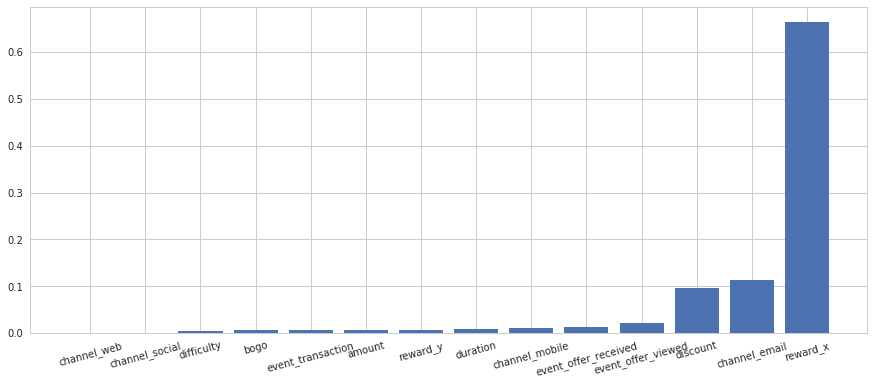

In [137]:
# Plot features as bar chart
plt.figure(figsize = [15, 6])
plt.bar(range(len(feat_imp)), list(feat_imp.values()),  align='center')
plt.xticks(range(len(feat_imp)), list(feat_imp.keys()))
plt.xticks(rotation=15);

### CONCLUSION

1.FEATURE ANALYSIS

From the visualization above the 3 features are the most important respectively:

- reward_x
- channel_email
- discount

Now lets take a look at each of the above on its own merit:
- The reward_x appears to be the most significant feature when it comes to offer completion. Its possible that the higher the reward the higher the chance of the offer being completed. The rewards are creating value by motivating Starbucks customers to try a product by completing the offer. Starbucks can use the rewards to create a programs that rewards customer loyalty. Delivering increased value in form of rewards to profitable customers turns them into loyal customers; and that loyal customers become even more profitable over time.

- Channel email doesnt appear to be as influential a feature as reward_x but it does show the delivery system most effective in offer completions. Starbucks can use this by sending more through emails and further fine tuning the process to find out why the channel is effective.

- The 3rd feature in order of importance is discount which is an offer type. This is not surprising as customers are known to respond positively to discounts. Giving customers a discount might just be the thing to draw them in and become a recurring  customer. And new customers mean new opportunities for cross-sells and upsells, meaning more revenue in the long run as well. Therefore Starbucks might look at how to give more discounts to its customers instead of other offers.


2.RESULTS EVALUATION
All the models from above were all analyzed using the Root Mean Square Error(RMSE) and cross validation. 
RMSE is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. 
The RMSE from our models above are:
- Baseline Model: Train RMSE error: 0.06461127565148764, Test RMSE error: 0.13643719402592924
- xbg Regressor model performance:- Train RMSE error: 0.05210123211145401, Test RMSE error: 0.12047526985406876
- Random Forest Model: 0.06368740514313077, Test RMSE error: 0.15087425084601191
- Decision Tree model performance:- Train RMSE error: 0.0, Test RMSE error: 0.21780048291891418
- GridSearchSv Tuned Model: Train RMSE error: 0.05766602233052254, Test RMSE error: 0.10836191475391388 

Cross-validation is a technique for evaluating ML models by training several ML models on subsets of the available input data and evaluating them on the complementary subset of the data. The best cross validation score was from xgbRegressor at 0.142.

As can be seen from above the GridSearchSv model performed the best as it had the least errors both in the Train and Test sets and the cross validation. In the Random Forest Regression Model the training data performed better slightly than the Baseline model but the test is worse off. This might be explained by overfitting in the Baseline model. 
The xbg Regressor model also performed best among all the other models with a cross validation error of 0.142. Even though the Train RMSE was a bit lower than the tuned RMSE, the tuned test RMSE was better. The cross validation also became better at 0.11725761365145668. 

3. IMPROVEMENTS AND CONCLUSION

- The first improvement that can be made is on preprocessing of data. It was quite challenging finding a way to work out how to put all the data together meaningfully. I chose to aggregate the data to make customer offer events and transactions together. There can be other ways to bring the data together by keeping the individuality of each transaction intact.
- Someone with deeper coffee retail industry knowledge might be able to select better target and feature variables or even come up with new ones that will make it easier to predict which customers will complete offers.
- We can also go further by finding out what the optimal rewards and discounts are to get more customers completing the offers.
- A proper experiment can be set up eg A/B testing to determine the effects of sending offers through emails or other platforms. Different reward systems and discounts can also be tested for effectiveness.
- It will definately be useful to dig deeper and find features that affect specific demographics to find what makes completions successful. Income demographics and age are definately interesting routes that can be explored.

In conclusion Starbucks can send more of its discount offer through the email channel and also have a good reward system. By creating a reward program that keeps customers loyal over a long period of time while also encouraging them to spend more on Starbucks products.